I have use @amyjang's wonderful <a href = 'https://www.kaggle.com/amyjang/monet-cyclegan-tutorial'>code</a> to run this on a TPU. I've modified the generator to have a resnet structure with residual blocks described in the original paper.

## Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.2.0


## Load data

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TF records: ', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TF records: ', len(PHOTO_FILENAMES))

Monet TF records:  5
Photo TF records:  20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 255)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled = True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled = True).batch(1)

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

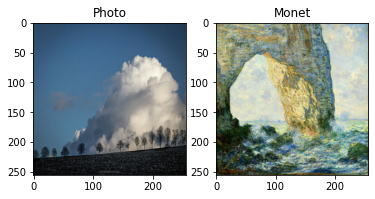

In [8]:
plt.subplot(1,2,1)
plt.title('Photo')
plt.imshow(example_photo[0])

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow(example_monet[0])

## Building up the model

In [9]:
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

In [10]:
class ConstantPadding2D(layers.Layer):
    '''Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    '''
    
    def __init__(self, padding = (1,1), **kwargs):
        self.padding = padding
        super(ConstantPadding2D, self).__init__(**kwargs)
        
    def call(self, input_tensor, mask = None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0,0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0,0]
        ]
        return tf.pad(input_tensor, padding_tensor, mode = 'CONSTANT')
    
def residual_block(
    x,
    activation,
    kernel_initializer = kernel_init,
    kernel_size = (3,3),
    strides = (1,1),
    padding = 'valid',
    gamma_initializer = gamma_init,
    use_bias = False,
):
    dim = x.shape[-1]
    input_tensor = x
    
    x = ConstantPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides = strides,
        kernel_initializer = kernel_initializer,
        padding = padding,
        use_bias = use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
    x = activation(x)
    x = ConstantPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides = strides,
        kernel_initializer = kernel_initializer,
        padding = padding,
        use_bias = use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x

def downsample(
    x,
    filters,
    activation,
    kernel_initializer = kernel_init,
    kernel_size = (3,3),
    strides = (2,2),
    padding = 'same',
    gamma_initializer = gamma_init,
    use_bias = False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides = strides,
        kernel_initializer = kernel_initializer,
        padding = padding,
        use_bias = use_bias,
    )(x)
    if activation:
        x = activation(x)
    return x

def upsample(
    x,
    filters,
    activation,
    kernel_initializer = kernel_init,
    kernel_size = (3,3),
    strides = (2,2),
    padding = 'same',
    gamma_initializer = gamma_init,
    use_bias = False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides = strides,
        padding = padding,
        kernel_initializer = kernel_initializer,
        use_bias = use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

## Building the generator

In [11]:
def resnet_generator(
    filters = 64,
    num_downsampling_blocks = 2,
    num_residual_blocks = 9,
    num_upsampling_blocks = 2,
    gamma_initializer = gamma_init,
    name = None,
):
    img_input = layers.Input(shape = (256,256,3), name = name + '_img_input')
    x = ConstantPadding2D(padding = (3,3))(img_input)
    x = layers.Conv2D(filters, (7,7), kernel_initializer = kernel_init, use_bias = False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer = gamma_initializer)(x)
    x = layers.Activation('relu')(x)
    
    #Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters = filters, activation = layers.Activation('relu'))
        
    #Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation = layers.Activation('relu'))
        
    #Upsampling
    for _ in range(num_upsampling_blocks):
        filters //= 2
        x = upsample(x, filters = filters, activation = layers.Activation('relu'))
        
    #final block
    x = ConstantPadding2D(padding = (3,3))(x)
    x = layers.Conv2D(3, (7,7), padding = 'valid')(x)
    x = layers.Activation('tanh')(x)
    
    model = keras.models.Model(img_input, x, name = name)
    return model

## Building the discriminator

In [12]:
def discriminator(
    filters = 64,
    kernel_initializer = kernel_init,
    num_downsampling = 3,
    name = None,
):
    img_input = layers.Input(shape = (256,256,3), name = name + '_img_input')
    x = layers.Conv2D(
        filters,
        (4,4),
        strides = (2,2),
        padding = 'same',
        kernel_initializer = kernel_initializer,
        )(img_input)
    x = layers.LeakyReLU(0.2)(x)
    
    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters = num_filters,
                activation = layers.LeakyReLU(0.2),
                kernel_size = (4,4),
                strides = (2,2),
            )
        else:
            x = downsample(
                x,
                filters = num_filters,
                activation = layers.LeakyReLU(0.2),
                kernel_size = (4,4),
                strides = (1,1),
            )
    x = layers.Conv2D(1, (4,4), strides = (1,1), padding = 'same', kernel_initializer = kernel_initializer)(x)
    model = keras.models.Model(img_input, x, name = name)
    return model

## Building the GAN

In [13]:
with strategy.scope():
    monet_generator = resnet_generator(name = 'generator_monet')  #transforms photos to monet
    photo_generator = resnet_generator(name = 'generator_photo')  #transforms monet to photos
    monet_discriminator = discriminator(name = 'discriminator_monet') #differentiates between real monets and generated monets
    photo_discriminator = discriminator(name = 'discriminator_photo') #differentiates between real photos and generated photos

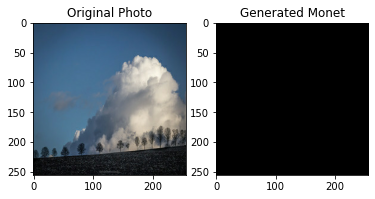

In [14]:
to_monet = monet_generator(example_photo)

plt.subplot(1,2,1)
plt.title('Original Photo')
plt.imshow(example_photo[0])

plt.subplot(1,2,2)
plt.title('Generated Monet')
plt.imshow(to_monet[0])

In [15]:
class CycleGAN(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle = 10.0,
        lambda_identity = 0.5
    ):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
    
    def train_step(self, batch):
        real_monet, real_photo = batch
        with tf.GradientTape(persistent = True) as tape:
            #photo --> monet --> photo
            fake_monet = self.m_gen(real_photo, training = True)
            cycled_photo = self.p_gen(fake_monet, training = True)
            
            #monet --> photo --> monet
            fake_photo = self.p_gen(real_monet, training = True)
            cycled_monet = self.m_gen(fake_photo, training = True)
            
            #identity mapping
            same_monet = self.m_gen(real_monet, training = True)
            same_photo = self.p_gen(real_photo, training = True)
            
            #discriminator output
            disc_real_monet = self.m_disc(real_monet, training = True)
            disc_fake_monet = self.m_disc(fake_monet, training = True)
            
            disc_real_photo = self.p_disc(real_photo, training = True)
            disc_fake_photo = self.p_disc(fake_photo, training = True)
            
            #generator cycle losses
            cycled_loss_monet = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle)
            cycled_loss_photo = self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_cycle_loss = cycled_loss_monet + cycled_loss_photo
            
            #generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            #identity losses
            monet_id_loss = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle, self.lambda_identity)
            photo_id_loss = self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle, self.lambda_identity)
            total_id_loss = monet_id_loss + photo_id_loss
            
            #total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + total_id_loss
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + total_id_loss
            
            #discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        
        #calculate gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }
        

## Loss functions

In [16]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        fake_loss = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + fake_loss
        return total_disc_loss*0.5     

In [17]:
with strategy.scope():
    def generator_loss(generated):
        return keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [18]:
with strategy.scope():
    def cycle_loss(real_image, cycled_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return loss*LAMBDA

In [19]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA1, LAMBDA2):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return loss*LAMBDA1*LAMBDA2

## Train 

In [20]:
with strategy.scope():
    m_gen_optimizer = keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5)
    p_gen_optimizer = keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5)
    m_disc_optimizer = keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5)
    p_disc_optimizer = keras.optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    cycle_gan_model.compile(
        m_gen_optimizer = m_gen_optimizer,
        p_gen_optimizer = p_gen_optimizer,
        m_disc_optimizer = m_disc_optimizer,
        p_disc_optimizer = p_disc_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = cycle_loss,
        identity_loss_fn = identity_loss)

In [22]:
history = cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs = 50)

Epoch 1/50
300/300 [==============================] - 101s 336ms/step - photo_disc_loss: 0.5600 - monet_disc_loss: 0.6167 - photo_gen_loss: 6.4041 - monet_gen_loss: 6.2030
Epoch 2/50
300/300 [==============================] - 101s 335ms/step - photo_disc_loss: 0.6404 - monet_disc_loss: 0.6315 - photo_gen_loss: 4.9120 - monet_gen_loss: 4.9261
Epoch 3/50
300/300 [==============================] - 101s 335ms/step - photo_disc_loss: 0.6510 - monet_disc_loss: 0.6614 - photo_gen_loss: 4.5322 - monet_gen_loss: 4.5069
Epoch 4/50
300/300 [==============================] - 101s 335ms/step - photo_disc_loss: 0.6503 - monet_disc_loss: 0.6746 - photo_gen_loss: 4.2397 - monet_gen_loss: 4.1722
Epoch 5/50
300/300 [==============================] - 101s 335ms/step - photo_disc_loss: 0.6445 - monet_disc_loss: 0.6869 - photo_gen_loss: 4.0772 - monet_gen_loss: 3.9976
Epoch 6/50
300/300 [==============================] - 101s 335ms/step - photo_disc_loss: 0.6472 - monet_disc_loss: 0.6681 - photo_gen_loss: 

## Visualising predictions

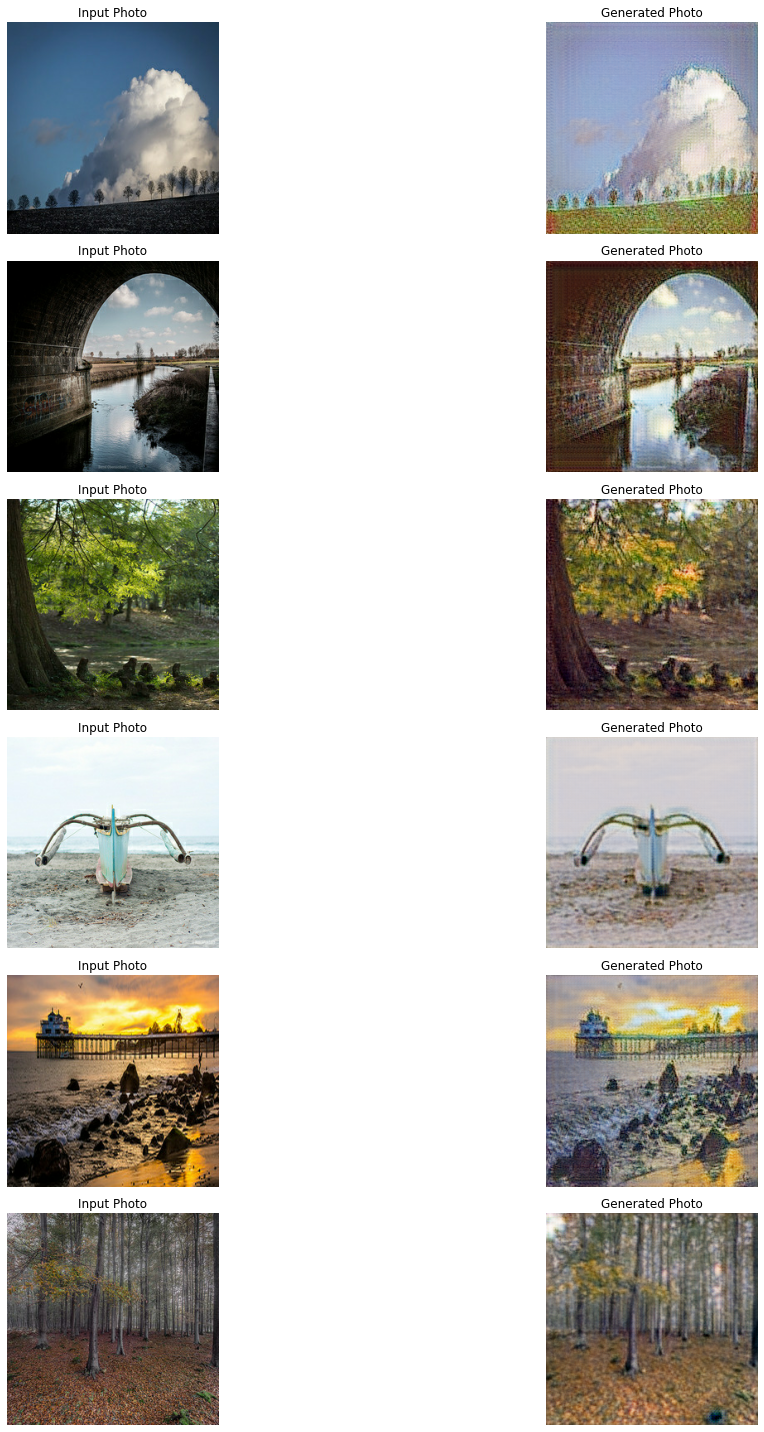

In [23]:
_, ax = plt.subplots(6,2,figsize = (20,20))
for i, img in enumerate(photo_ds.take(6)):
    prediction = monet_generator(img, training = False)[0].numpy()
    prediction = prediction
    img = (img[0]).numpy()
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title('Input Photo')
    ax[i, 1].set_title('Generated Photo')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

## submission

In [24]:
import PIL
! mkdir ../images

In [25]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction*255).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [26]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'